In [2]:
import cProfile
import pstats
import random
import numpy as np
from NSGPy import NSGP, plot_nsgp_1d

In [3]:
from NSGPy.utils.linalg import cholesky_with_jitter, solve_cholesky_L, solve_cholesky, cholesky_inverse
from scipy.linalg import lapack, blas

def random_spd_matrix(n, seed=None):
    """
    Generate a random symmetric positive definite (SPD) matrix of size (n, n).

    :param n: Size of the matrix (n x n).
    :param seed: Random seed for reproducibility.
    :return: SPD matrix of shape (n, n).
    """
    if seed is not None:
        np.random.seed(seed)

    G = np.random.randn(n, n)  # Random Gaussian matrix
    A = np.dot(G, G.T)  # Construct SPD matrix (ensures symmetry & PD)

    return A


def cholesky_inverse_s(L, I, lower=True):
    """
    Computes the inverse of a symmetric positive definite matrix using Cholesky.
    Optimized to be faster than dpotri.

    :param L: Symmetric positive definite matrix
    :param lower: Whether to use lower-triangular Cholesky factor
    :returns: Inverse of A
    """
    # Compute L⁻¹ using dtrtrs (in-place inversion of a triangular matrix)
    L_inv, info = lapack.dtrtrs(L,  I, lower=lower, unitdiag=False)
    if info != 0:
        raise ValueError("Triangular matrix inversion failed.")

    # Compute A⁻¹ = L⁻ᵀ * L⁻¹
    return L_inv.T @ L_inv

A = random_spd_matrix(400)
b = np.random.random((400))
L = cholesky_with_jitter(A)
I = np.eye(L.shape[0], order='F')

#print(cholesky_inverse(A))
#print(np.linalg.inv(A))

#%timeit np.linalg.inv(A)           # numpy inv
#%timeit cholesky_inverse(L)        # triangular inverse, A = L_inv.T @ L_inv (dtrtri)
#%timeit cholesky_inverse_s(L, I)   # triangular solve, A = L_inv.T @ L_inv (dtrtrs)
#%timeit solve_cholesky(L, I)       # cholesky solve (dpotrs)
#%timeit solve_cholesky_L(L, I)     # forward backward (dtrtrs)

#for n_samples in [1, 5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250, 300, 400, 600, 800, 1000, 1500, 2000]:
#    print(f"Time for {n_samples} n_samples:")
#    A = random_spd_matrix(n_samples)
#    b = np.random.random((n_samples))
#    L = cholesky_with_jitter(A)
#    I = np.eye(L.shape[0], order='F')

#    %timeit np.linalg.inv(A)         # numpy inv
#    %timeit cholesky_inverse(L)      # triangular inverse, A = L_inv.T @ L_inv (dtrtri)
#    %timeit cholesky_inverse_s(L, I) # triangular solve, A = L_inv.T @ L_inv (dtrtrs)
#    %timeit solve_cholesky(L, I)     # cholesky solve (dpotrs)
#    %timeit solve_cholesky_L(L, I)   # forward backward (dtrtrs)

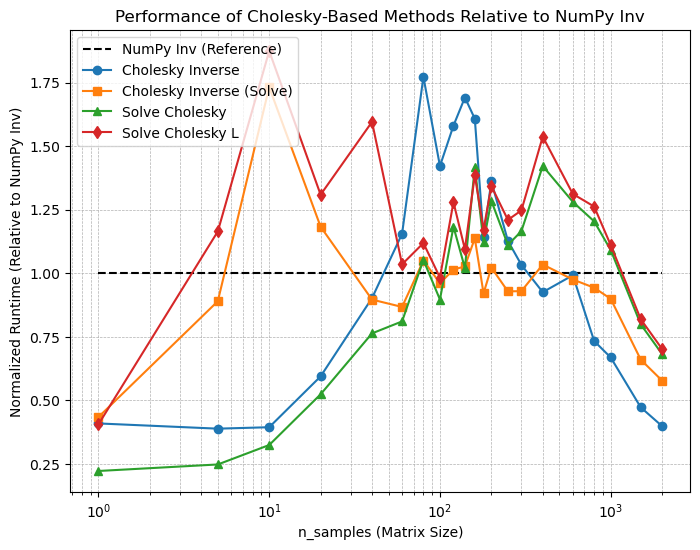

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Sample sizes
n_samples = [1, 5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250, 300, 400, 600, 800, 1000, 1500, 2000]

# Timings (in microseconds)
numpy_inv = np.array([2.79, 3.35, 4.14, 6.67, 17.3, 31.6, 42.2, 80.9, 93, 149, 153, 252, 274, 558, 834, 1470, 4810, 10300, 20800, 79900, 201000])
cholesky_inv = np.array([1.14, 1.3, 1.63, 3.96, 15.6, 36.5, 74.8, 115, 147, 252, 246, 288, 373, 629, 861, 1360, 4770, 7550, 13900, 37700, 80000])
cholesky_inv_s = np.array([1.21, 2.98, 7.17, 7.89, 15.5, 27.4, 44.3, 77.7, 94.3, 153, 174, 232, 280, 518, 775, 1520, 4690, 9710, 18700, 52700, 116000])
solve_cholesky = np.array([0.618, 0.828, 1.34, 3.49, 13.2, 25.6, 44.4, 72.5, 110, 152, 217, 283, 352, 620, 972, 2090, 6160, 12400, 22700, 63800, 137000])
solve_cholesky_L = np.array([1.13, 3.9, 7.76, 8.73, 27.6, 32.7, 47.2, 79.5, 119, 163, 212, 295, 368, 675, 1040, 2260, 6310, 13000, 23100, 65400, 141000])

# Normalize all values by numpy_inv times
cholesky_inv /= numpy_inv
cholesky_inv_s /= numpy_inv
solve_cholesky /= numpy_inv
solve_cholesky_L /= numpy_inv

# Create log-log plot
plt.figure(figsize=(8, 6))
plt.plot(n_samples, np.ones_like(numpy_inv), label="NumPy Inv (Reference)", linestyle="dashed", color="black")
plt.plot(n_samples, cholesky_inv, label="Cholesky Inverse", marker="o")
plt.plot(n_samples, cholesky_inv_s, label="Cholesky Inverse (Solve)", marker="s")
plt.plot(n_samples, solve_cholesky, label="Solve Cholesky", marker="^")
plt.plot(n_samples, solve_cholesky_L, label="Solve Cholesky L", marker="d")

plt.xlabel("n_samples (Matrix Size)")
plt.ylabel("Normalized Runtime (Relative to NumPy Inv)")
plt.title("Performance of Cholesky-Based Methods Relative to NumPy Inv")
plt.xscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [5]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define function
def f(x1, x2):
    return np.sin((x1 * 6) ** 4 * 0.005) * np.sin((x2 * 6) ** 4 * 0.005)

# Create grid
x1 = np.linspace(0, 1, 20)
x2 = np.linspace(0, 1, 20)
X1, X2 = np.meshgrid(x1, x2)
Xt = np.column_stack((X1.ravel(), X2.ravel()))

# Compute function values
y_pred2D = f(X1, X2)

# Reshape to column vector
y_pred2D = y_pred2D.reshape(-1,1)

# Train NSGP model
# Initialize the NSGP model
lgp = NSGP()

# Set the optimization parameters (optional)
lgp.optimizer(optimizer="grad", random_restarts=9, max_iteration=5000)

# Train the NSGP model with training data
# The last argument "ls" specifies which nonstationary functions to learn (lengthscale, signal variance)
lgp.fit(Xt, y_pred2D, "ls")

Optimizing for 9 restarts ...
  model   iter stepsize       mll
ls   gp      1    -5.00   5965.46
ls   gp    100    -5.57   7117.58
ls   gp    200    -6.93   7121.86
ls   gp    217    -7.01   7122.19
ls   gp      1    -5.00   6057.88
ls   gp     76    -7.15   6915.80
ls   gp      1    -5.00   1667.56
ls   gp    100    -4.20   7146.22
ls   gp    198    -7.01   7162.96
ls   gp      1    -5.00   5802.88
ls   gp     83    -7.06   6997.28
ls   gp      1    -5.00   5394.25
ls   gp    100    -4.59   7144.83
ls   gp    121    -7.06   7151.70
ls   gp      1    -5.00  -1110.93
ls   gp    100    -4.00   7146.72
ls   gp    121    -7.06   7147.51
ls   gp      1    -5.00   6119.51
ls   gp    100    -6.36   7162.52
ls   gp    198    -7.01   7163.78
ls   gp      1    -5.00   5762.81
ls   gp    100    -6.16   7082.00
ls   gp    106    -7.09   7082.00
ls   gp      1    -5.00   6143.07
ls   gp    100    -6.36   7161.80
ls   gp    169    -7.03   7163.27
Best model mll=7163.78


In [6]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Run cProfile
cProfile.run("lgp.fit(Xt, y_pred2D, 'ls')", "output.prof")

# Analyze results
p = pstats.Stats("output.prof")
p.strip_dirs().sort_stats("tottime").print_stats(20)  # Show top 10 slowest functions

Optimizing for 9 restarts ...
  model   iter stepsize       mll
ls   gp      1    -5.00   5965.46
ls   gp    100    -5.57   7117.58
ls   gp    200    -6.93   7121.86
ls   gp    217    -7.01   7122.19
ls   gp      1    -5.00   6057.88
ls   gp     76    -7.15   6915.80
ls   gp      1    -5.00   1667.56
ls   gp    100    -4.20   7146.22
ls   gp    198    -7.01   7162.96
ls   gp      1    -5.00   5802.88
ls   gp     83    -7.06   6997.28
ls   gp      1    -5.00   5394.25
ls   gp    100    -4.59   7144.83
ls   gp    121    -7.06   7151.70
ls   gp      1    -5.00  -1110.93
ls   gp    100    -4.00   7146.72
ls   gp    121    -7.06   7147.51
ls   gp      1    -5.00   6119.51
ls   gp    100    -6.36   7162.52
ls   gp    198    -7.01   7163.78
ls   gp      1    -5.00   5762.81
ls   gp    100    -6.16   7082.00
ls   gp    106    -7.09   7082.00
ls   gp      1    -5.00   6143.07
ls   gp    100    -6.36   7161.80
ls   gp    169    -7.03   7163.27
Best model mll=7163.78
Thu Apr  3 13:26:52 2025    o

In [ ]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Run cProfile
cProfile.run("lgp.fit(Xt, y_pred2D, 'ls')", "output.prof")

# Analyze results
p = pstats.Stats("output.prof")
p.strip_dirs().sort_stats("tottime").print_stats(20)  # Show top 10 slowest functions

Optimizing for 9 restarts ...
  model   iter stepsize       mll
ls   gp      1    -5.00   5965.46
ls   gp    100    -5.57   7117.58
ls   gp    200    -6.93   7121.86
ls   gp    217    -7.01   7122.19
ls   gp      1    -5.00   6057.88
ls   gp     76    -7.15   6915.80
ls   gp      1    -5.00   1667.56
ls   gp    100    -4.20   7146.22
ls   gp    198    -7.01   7162.96
ls   gp      1    -5.00   5802.88
ls   gp     83    -7.06   6997.28
ls   gp      1    -5.00   5394.25
ls   gp    100    -4.59   7144.83
ls   gp    121    -7.06   7151.70
ls   gp      1    -5.00  -1110.93
ls   gp    100    -4.00   7146.72
ls   gp    121    -7.06   7147.51
ls   gp      1    -5.00   6119.51
ls   gp    100    -6.36   7162.52
ls   gp    198    -7.01   7163.78
ls   gp      1    -5.00   5762.81
ls   gp    100    -6.16   7082.00
ls   gp    106    -7.09   7082.00
ls   gp      1    -5.00   6143.07


In [ ]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define function
def f(x1, x2, x3):
    return np.sin((x1 * 6) ** 4 * 0.005) * np.sin((x2 * 6) ** 4 * 0.005) * np.sin((x3 * 6) ** 4 * 0.005)

# Create grid
x1 = np.linspace(0, 1, 10)
x2 = np.linspace(0, 1, 10)
x3 = np.linspace(0, 1, 10)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
Xt = np.column_stack((X1.ravel(), X2.ravel(), X3.ravel()))

# Compute function values
y_pred3D = f(X1, X2, X3)

# Reshape to column vector
y_pred3D = y_pred3D.reshape(-1,1)

# Train NSGP model
# Initialize the NSGP model
lgp = NSGP()

# Set the optimization parameters (optional)
lgp.optimizer(optimizer="grad", random_restarts=5, max_iteration=5000)

# Train the NSGP model with training data
# The last argument "ls" specifies which nonstationary functions to learn (lengthscale, signal variance)
# lgp.fit(Xt, y_pred3D, "ls")
# Run cProfile
cProfile.run("lgp.fit(Xt, y_pred3D, 'ls')", "output.prof")

Optimizing for 5 restarts ...
  model   iter stepsize       mll
ls   gp      1    -5.00   9815.72
ls   gp    100    -3.22  12574.21
ls   gp    154    -7.07  12865.55
ls   gp      1    -5.00  10044.26
ls   gp     92    -7.08  11495.18
ls   gp      1    -5.00   4560.69
ls   gp     96    -7.11  12573.07
ls   gp      1    -5.00   9466.90
ls   gp    100    -4.00  13252.47
ls   gp    125    -7.09  13263.18
ls   gp      1    -5.00  10117.10
ls   gp    100    -7.14  13022.42
ls   gp    100    -7.14  13022.42
Best model mll=13263.18


In [ ]:
# Analyze results
p = pstats.Stats("output.prof")
p.strip_dirs().sort_stats("tottime").print_stats(20)  # Show top 10 slowest functions

Thu Mar 20 11:24:40 2025    output.prof

         196147 function calls (196136 primitive calls) in 70.313 seconds

   Ordered by: internal time
   List reduced from 191 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2473   18.918    0.008   22.021    0.009 linalg.py:78(cholesky_with_jitter)
      567   14.813    0.026   14.829    0.026 _linalg.py:493(inv)
      567    5.359    0.009   32.576    0.057 gradients.py:8(lengthscale_gradient)
      745    4.873    0.007    8.182    0.011 nonstationary.py:5(ns_rbf_kernel)
      577    4.462    0.008    5.341    0.009 linalg.py:67(cholesky)
     3050    3.982    0.001    3.982    0.001 {built-in method numpy.asfortranarray}
     2835    2.957    0.001    2.957    0.001 {built-in method numpy._core._multiarray_umath.c_einsum}
     4156    2.504    0.001    2.511    0.001 linalg.py:112(solve_cholesky)
     1879    2.040    0.001    2.040    0.001 {method 'outer' of 'numpy.ufunc' objec

In [ ]:
# Analyze results
p = pstats.Stats("output.prof")
p.strip_dirs().sort_stats("tottime").print_stats(20)  # Show top 10 slowest functions

Thu Mar 20 11:27:04 2025    output.prof

         183330 function calls in 74.245 seconds

   Ordered by: internal time
   List reduced from 140 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2473   20.040    0.008   24.132    0.010 linalg.py:78(cholesky_with_jitter)
      567    8.984    0.016    8.984    0.016 linalg.py:162(cholesky_inverse)
      567    6.901    0.012   30.612    0.054 gradients.py:8(lengthscale_gradient)
      745    6.392    0.009   10.845    0.015 nonstationary.py:5(ns_rbf_kernel)
     3050    5.285    0.002    5.285    0.002 {built-in method numpy.asfortranarray}
      577    4.656    0.008    5.850    0.010 linalg.py:67(cholesky)
     2835    3.402    0.001    3.402    0.001 {built-in method numpy._core._multiarray_umath.c_einsum}
     4156    3.222    0.001    3.231    0.001 linalg.py:112(solve_cholesky)
     1879    2.842    0.002    2.842    0.002 {method 'outer' of 'numpy.ufunc' objects}
     1879

In [ ]:
from nsgpytorch import nsgp, plot_nsgp_1d, plot_nsgp_2d, nsgp_posterior, NSGP, plot_kernel_1d
import torch
import cProfile
import pstats

torch.set_default_dtype(torch.float64) 
torch.set_grad_enabled(False)

In [ ]:
class TrueModel:
    def __init__(self, x, f):
        self.x = x
        self.f = f

Optimizing 4 targets with 9 restarts using 36 parallel processes...
Starting Process 0 in slot 0
Starting Process 1 in slot 1
Starting Process 2 in slot 2
Starting Process 3 in slot 3
Starting Process 4 in slot 4
Starting Process 5 in slot 5
Starting Process 6 in slot 6
Starting Process 7 in slot 7
Starting Process 8 in slot 8
Starting Process 9 in slot 9
Starting Process 10 in slot 10
Starting Process 11 in slot 11
Starting Process 12 in slot 12
Starting Process 13 in slot 13
Starting Process 14 in slot 14
Starting Process 15 in slot 15
Starting Process 16 in slot 16
Starting Process 17 in slot 17
Starting Process 18 in slot 18
Starting Process 19 in slot 19
Starting Process 20 in slot 20
Starting Process 21 in slot 21
Starting Process 22 in slot 22
Starting Process 23 in slot 23
Starting Process 24 in slot 24
Starting Process 25 in slot 25
Starting Process 26 in slot 26
Starting Process 27 in slot 27
Starting Process 28 in slot 28
Starting Process 29 in slot 29
Starting Process 30 in

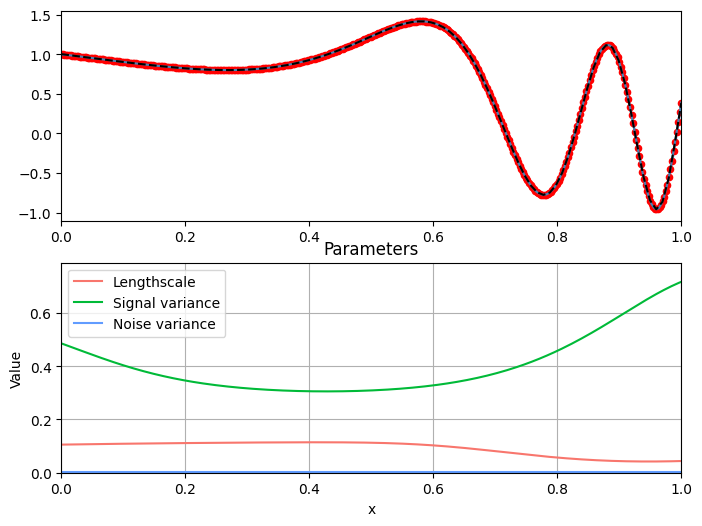

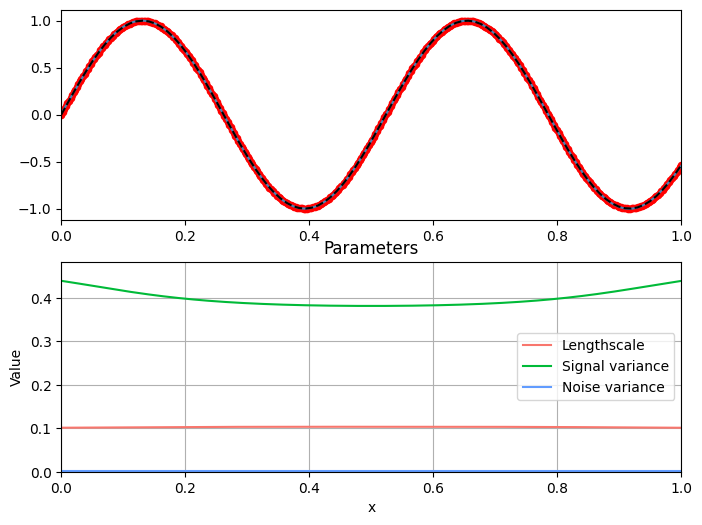

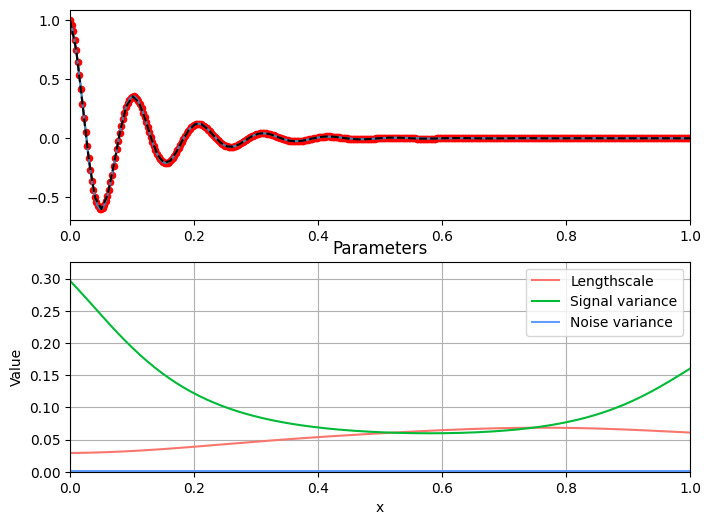

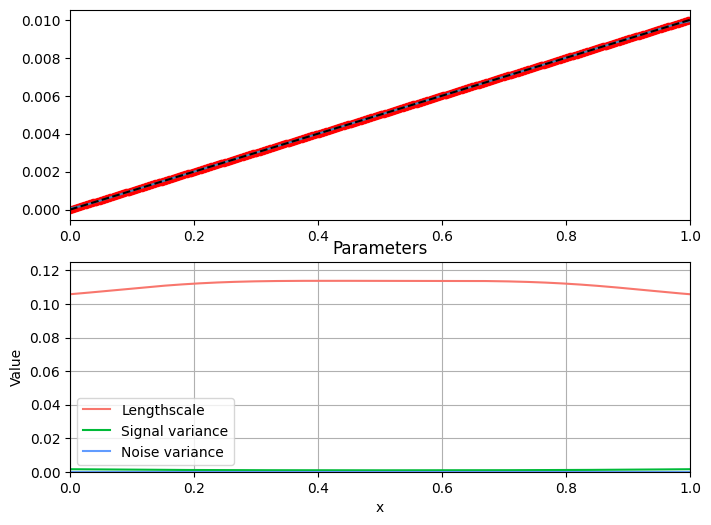

In [ ]:
def f1(x1):
    """Defines a smooth function without noise."""
    return torch.sin((x1 * 6) ** 4 * 0.01) + (1 - x1)

def f2(x1):
    """Defines a second target function."""
    return torch.sin(((x1) * 12)) # Example different function

def f3(x1):
    return torch.cos(3*x1*20) * torch.exp(-0.5*x1*20)

def f4(x1):
    return x1*0.01

# Generate training data (input values)
Xt = torch.linspace(0, 1, 400).reshape(-1,1)  # 10 evenly spaced points between 0 and 1
y1_pred1D = f1(Xt).reshape(-1,1)  # Compute corresponding function values
y2_pred1D = f2(Xt).reshape(-1,1) 
y3_pred1D = f3(Xt).reshape(-1,1) 
y4_pred1D = f4(Xt).reshape(-1,1) 

# Stack outputs to form a multi-output dataset
y_pred_multi = torch.cat([y1_pred1D, y2_pred1D, y3_pred1D, y4_pred1D], dim=1)  # Shape: (10, 2)

# Initialize the NSGP model
lgp = NSGP()

# Define hyperparameters for the NSGP model (optional)
hyperparameters = {
    "initial_lengthscale": [0.01, 0.05, 0.1, 0.01, 0.05, 0.1, 0.01, 0.05, 0.1],      # Initial lengthscale for the kernel
    "initial_signal_variance": [0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5],   # Initial signal variance
    "initial_noise_variance": [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],   # Initial noise variance
    "beta_lengthscale": 0.2,       # Controls variation of lengthscale
    "beta_signal_variance": 0.2,   # Controls variation of signal variance
    "beta_noise_variance": 0.3,    # Controls variation of noise variance
    "alpha_lengthscale": 1,        # Alpha parameter for lengthscale
    "alpha_signal_variance": 1,    # Alpha parameter for signal variance
    "alpha_noise_variance": 1,     # Alpha parameter for noise variance
    "verbose_output": True,
}

lgp.set_params(**hyperparameters)

# Set the optimization parameters (optional)
lgp.optimizer(optimizer="grad", n_restarts=9, max_iteration=5000)

# Train the NSGP model with training data
# The last argument "ls" specifies which nonstationary functions to learn (lengthscale, signal variance)
lgp.fit(Xt, y_pred_multi, "ls", batch_size=36)

# Generate test data for true function visualization (optional)
Xt_true = torch.linspace(0, 1, 100).reshape(-1,1)  # 100 test points for smooth function visualization
y1_true1D = f1(Xt_true).reshape(-1,1)  # Compute true function values
y2_true1D = f2(Xt_true).reshape(-1,1)  # Compute true function values
y3_true1D = f3(Xt_true).reshape(-1,1)  # Compute true function values
y4_true1D = f4(Xt_true).reshape(-1,1)  # Compute true function values
y_true_multi = torch.cat([y1_true1D, y2_true1D, y3_true1D, y4_true1D], dim=1)  # (n_samples, n_targets)
truemodel = TrueModel(Xt_true, y_true_multi)  # Store true model data for comparison

# Plot the NSGP model results
# - `plotlatent=True` to visualize learned latent parameters (like lengthscale)
# - `plotderivs=False` to disable derivative visualization
# - `truemodel=truemodel` to compare with the true function
plot_nsgp_1d(lgp.gp, plotlatent=True, plotderivs=False, truemodel=truemodel)

In [ ]:
cProfile.run("lgp.fit(Xt, y_pred_multi, 'ls', batch_size=36)", "output.prof")

Optimizing 4 targets with 9 restarts using 36 parallel processes...
Starting Process 0 in slot 0
Starting Process 1 in slot 1
Starting Process 2 in slot 2
Starting Process 3 in slot 3
Starting Process 4 in slot 4
Starting Process 5 in slot 5
Starting Process 6 in slot 6
Starting Process 7 in slot 7
Starting Process 8 in slot 8
Starting Process 9 in slot 9
Starting Process 10 in slot 10
Starting Process 11 in slot 11
Starting Process 12 in slot 12
Starting Process 13 in slot 13
Starting Process 14 in slot 14
Starting Process 15 in slot 15
Starting Process 16 in slot 16
Starting Process 17 in slot 17
Starting Process 18 in slot 18
Starting Process 19 in slot 19
Starting Process 20 in slot 20
Starting Process 21 in slot 21
Starting Process 22 in slot 22
Starting Process 23 in slot 23
Starting Process 24 in slot 24
Starting Process 25 in slot 25
Starting Process 26 in slot 26
Starting Process 27 in slot 27
Starting Process 28 in slot 28
Starting Process 29 in slot 29
Starting Process 30 in

In [ ]:
p = pstats.Stats("output.prof")
p.strip_dirs().sort_stats("tottime").print_stats(40)  # Show top 10 slowest functions

Wed Mar 26 15:14:13 2025    output.prof

         30742 function calls (30737 primitive calls) in 35.179 seconds

   Ordered by: internal time
   List reduced from 187 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      990   12.994    0.013   12.994    0.013 {built-in method torch.cholesky_solve}
      110    4.500    0.041   21.244    0.193 gradients.py:4(lengthscale_gradient)
     1112    3.550    0.003    3.550    0.003 {built-in method torch.exp}
      220    3.274    0.015    6.338    0.029 nonstationary.py:4(ns_rbf_kernel)
      232    2.771    0.012    2.771    0.012 {built-in method torch._C._linalg.linalg_cholesky_ex}
      440    1.498    0.003    1.498    0.003 {built-in method torch._C._linalg.linalg_cholesky}
      880    0.989    0.001    0.989    0.001 {built-in method torch.sqrt}
      110    0.913    0.008   13.755    0.125 gpmodel.py:141(compute_woodbury_matrix)
      110    0.687    0.006    1.503    0.014 gra

In [ ]:
p = pstats.Stats("output.prof")
p.strip_dirs().sort_stats("tottime").print_stats(20)  # Show top 10 slowest functions

Tue Mar 25 19:06:14 2025    output.prof

         47953 function calls (47948 primitive calls) in 38.739 seconds

   Ordered by: internal time
   List reduced from 184 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      110   12.722    0.116   12.722    0.116 {built-in method torch.cholesky_inverse}
      880    6.079    0.007    6.079    0.007 {built-in method torch.cholesky_solve}
      110    3.781    0.034   25.334    0.230 gradients.py:7(lengthscale_gradient)
      220    3.145    0.014    5.711    0.026 nonstationary.py:4(ns_rbf_kernel)
     1112    2.808    0.003    2.808    0.003 {built-in method torch.exp}
      562    2.785    0.005    2.785    0.005 {built-in method torch._C._linalg.linalg_cholesky_ex}
      110    1.357    0.012    1.357    0.012 {built-in method torch._C._linalg.linalg_cholesky}
      880    0.935    0.001    0.935    0.001 {built-in method torch.sqrt}
      110    0.815    0.007   18.983    0.173 gp

In [ ]:
# adaptive sampling test:
def adaptive_sampling():
    # Define function
    def f(x1, x2):
        return torch.sin((x1 * 6) ** 4 * 0.005) * torch.sin((x2 * 6) ** 4 * 0.005)

    # Create grid
    x1_train = torch.linspace(0, 1, 3)
    x2_train = torch.linspace(0, 1, 3)
    X1_train, X2_train = torch.meshgrid(x1_train, x2_train, indexing="ij")
    Xt_train = torch.column_stack((X1_train.ravel(), X2_train.ravel()))

    # Compute function values
    y_train = f(X1_train, X2_train)

    # Reshape to column vector
    y_train = y_train.reshape(-1,1)

    # Define hyperparameters for the NSGP model (optional)
    hyperparameters = {
        "initial_lengthscale": [0.01, 0.05, 0.1, 0.01, 0.05, 0.1, 0.01, 0.05, 0.1],      # Initial lengthscale for the kernel
        "initial_signal_variance": [0.05, 0.05, 0.05, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5],   # Initial signal variance
        "initial_noise_variance": [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],   # Initial noise variance
        "beta_lengthscale": 0.2,       # Controls variation of lengthscale
        "beta_signal_variance": 0.2,   # Controls variation of signal variance
        "beta_noise_variance": 0.3,    # Controls variation of noise variance
        "alpha_lengthscale": 1,        # Alpha parameter for lengthscale
        "alpha_signal_variance": 1,    # Alpha parameter for signal variance
        "alpha_noise_variance": 1,     # Alpha parameter for noise variance
        "verbose_output": False,
    }

    for i in range(100):
        print(f"Iteration {i+1}")

        # Initialize the NSGP model
        lgp = NSGP()

        # Set hyperparameters
        lgp.set_params(**hyperparameters)

        # Set the optimization parameters (optional)
        lgp.optimizer(optimizer="grad", n_restarts=5, max_iteration=5000)

        # Train the NSGP model with training data
        lgp.fit(Xt_train, y_train, "ls", batch_size=5)

        # Create evaluation grid
        x1_evaluate = torch.linspace(0, 1, 50)
        x2_evaluate = torch.linspace(0, 1, 50)
        X1_evaluate, X2_evaluate = torch.meshgrid(x1_evaluate, x2_evaluate, indexing="ij")
        Xt_evaluate = torch.column_stack((X1_evaluate.ravel(), X2_evaluate.ravel()))

        # Compute posterior values
        _, ftstd = lgp.predict(Xt_evaluate, return_std=True, return_cov=False) 

        # Find the location of highest uncertainty
        max_index = torch.argmax(ftstd)  # Index of max std
        new_sample = Xt_evaluate[max_index]  # Corresponding (x1, x2) point

        # Evaluate function at new sample
        new_y = f(*new_sample).reshape(1, 1)  # Ensure it's a column vector

        # Add new sample to training set
        Xt_train = torch.vstack((Xt_train, new_sample))
        y_train = torch.vstack((y_train, new_y))

    # Plot results
    plot_nsgp_2d(lgp.gp)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

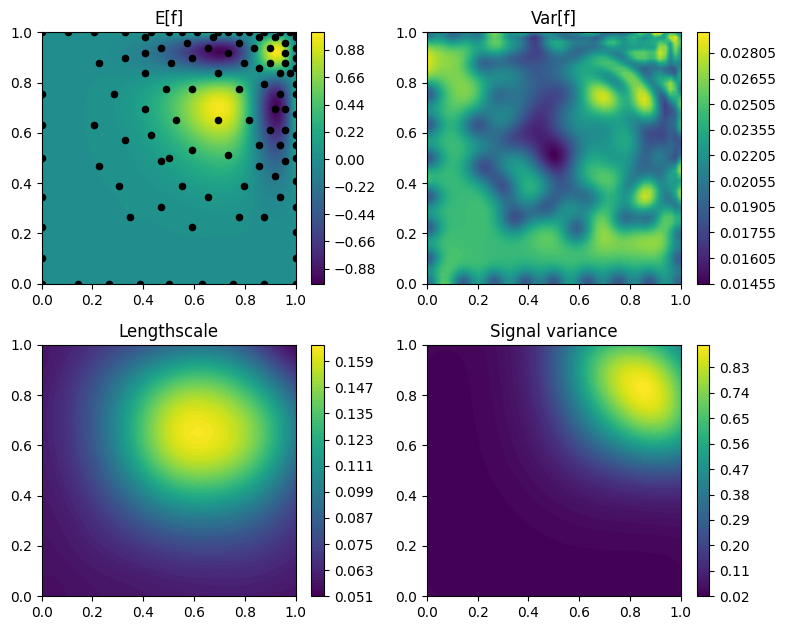

In [ ]:
cProfile.run("adaptive_sampling()", "output.prof")

In [ ]:
p = pstats.Stats("output.prof")
p.strip_dirs().sort_stats("tottime").print_stats(80)  # Show top 10 slowest functions

Wed Mar 26 15:08:39 2025    output.prof

         6368801 function calls (6332458 primitive calls) in 62.701 seconds

   Ordered by: internal time
   List reduced from 1833 to 80 due to restriction <80>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   183320    9.460    0.000    9.460    0.000 {built-in method torch.cholesky_solve}
    40950    6.828    0.000   14.146    0.000 nonstationary.py:4(ns_rbf_kernel)
   205951    3.991    0.000    3.991    0.000 {built-in method torch.exp}
    20324    3.860    0.000   22.402    0.001 likelihoods.py:77(nsgpmll)
    20324    3.706    0.000   20.513    0.001 gradients.py:4(lengthscale_gradient)
      100    3.316    0.033   55.523    0.555 optimizers.py:187(nsgpgrad)
    20324    2.999    0.000   51.310    0.003 optimizers.py:13(gradient_step)
    42956    2.779    0.000    2.779    0.000 {built-in method torch.cdist}
    81296    2.605    0.000    9.394    0.000 likelihoods.py:5(log_multivariate_normal_pdf)
    81700